## Flatten Model by spectrogram_sub_id

### imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time
from xgboost import XGBClassifier

import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### train.csv

In [3]:
train_file_path = '/content/drive/My Drive/HMS/train.csv'

In [4]:
df = pd.read_csv(train_file_path)

In [5]:
df.shape

(106800, 15)

In [6]:
df.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')

In [7]:
df['expert_consensus'].value_counts()

Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: expert_consensus, dtype: int64

In [8]:
filtered_df = df[df['spectrogram_sub_id'] == 0]
value_counts = filtered_df['expert_consensus'].value_counts()
print(value_counts)

Other      4699
Seizure    2045
GRDA       1422
LPD        1284
GPD        1025
LRDA        663
Name: expert_consensus, dtype: int64


In [9]:
le = LabelEncoder()

df['target_encoded'] = le.fit_transform(df['expert_consensus']) 

In [10]:
spectrogram_names = []
df_spec_and_sub = df[['spectrogram_id', 'spectrogram_sub_id', 'spectrogram_label_offset_seconds','target_encoded']].copy()

for index, row in df.iterrows():
    spectrogram_name = f"{row['spectrogram_id']}_{row['spectrogram_sub_id']}"
    spectrogram_names.append(spectrogram_name)
df_spec_and_sub['spectrogram_name'] = spectrogram_names

print(df_spec_and_sub.shape)
print(df_spec_and_sub.columns)
df_spec_and_sub.head(10)

(106800, 5)
Index(['spectrogram_id', 'spectrogram_sub_id',
       'spectrogram_label_offset_seconds', 'target_encoded',
       'spectrogram_name'],
      dtype='object')


,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,target_encoded,spectrogram_name
0,353733,0,0.0,5,353733_0
1,353733,1,6.0,5,353733_1
2,353733,2,8.0,5,353733_2
3,353733,3,18.0,5,353733_3
4,353733,4,24.0,5,353733_4
5,353733,5,26.0,5,353733_5
6,353733,6,30.0,5,353733_6
7,353733,7,36.0,5,353733_7
8,353733,8,40.0,5,353733_8
9,924234,0,0.0,0,924234_0


In [11]:
import random

random.seed(42)
np.random.seed(42)

sampled_df = pd.DataFrame()
sampled_spec_ids = set()

for target_class in range(len(le.classes_)):
    available_df = df_spec_and_sub[(df_spec_and_sub['target_encoded'] == target_class) & (~df_spec_and_sub['spectrogram_name'].isin(sampled_spec_ids))]
    n_samples = min(160, len(available_df))
    class_sample = available_df.sample(n=n_samples, random_state=42)
    sampled_df = pd.concat([sampled_df, class_sample])
    sampled_spec_ids.update(class_sample['spectrogram_name'].tolist())

df_spec_and_sub_random = sampled_df[['spectrogram_id', 'spectrogram_sub_id',
       'spectrogram_label_offset_seconds', 'target_encoded',
       'spectrogram_name']]

print("Sampled DataFrame shape:", df_spec_and_sub_random.shape)
print("Sample distribution:\n", df_spec_and_sub_random['target_encoded'].value_counts())
unique_spec_ids_in_split = df_spec_and_sub_random['spectrogram_name'].nunique()
print("Unique spec_id values in df_split:", unique_spec_ids_in_split)
df_spec_and_sub_random.sample(10)

Sampled DataFrame shape: (960, 5)
Sample distribution:
 0    160
1    160
2    160
3    160
4    160
5    160
Name: target_encoded, dtype: int64
Unique spec_id values in df_split: 960


,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,target_encoded,spectrogram_name
20469,394956001,32,180.0,5,394956001_32
40657,781427162,1,2.0,2,781427162_1
23046,447919898,17,342.0,2,447919898_17
8569,160482619,1,2.0,5,160482619_1
51337,1007938258,2,12.0,5,1007938258_2
41210,793532016,4,8.0,1,793532016_4
33507,655954200,20,82.0,1,655954200_20
3959,60873434,77,1014.0,2,60873434_77
13929,272214389,203,888.0,0,272214389_203
37467,740593948,4,42.0,5,740593948_4


In [12]:
df_spec_and_sub_random['spectrogram_id'].nunique()

794

In [13]:
del df_spec_and_sub
gc.collect()

31

### train.pqt

In [14]:
# train_pqt_file_path = '/content/drive/My Drive/HMS/train.pqt'

In [15]:
# df_pqt = pd.read_parquet(train_pqt_file_path, engine='pyarrow')

In [16]:
# df_pqt.shape

### specs.npy

In [18]:
def load_spectrograms(path, read_spec_files=False):

    if read_spec_files:
        spectrograms = {}
        for i,f in enumerate(files):
            if i%100==0: print(i,', ',end='')
            tmp = pd.read_parquet(f'{path}//{f}')
            name = int(f.split('.')[0])
            spectrograms[name] = tmp.iloc[:,1:].values
    else:
        spectrograms = np.load(f"{path}", allow_pickle=True).item()
    return spectrograms

In [20]:
def get_column_names():
    columns = []
    regions = ['LL_', 'RL_', 'LP_', 'RP_']
    increments = [
        0.59, 0.78, 0.98, 1.17, 1.37, 1.56, 1.76, 1.95, 2.15, 2.34,
        2.54, 2.73, 2.93, 3.13, 3.32, 3.52, 3.71, 3.91, 4.1, 4.3,
        4.49, 4.69, 4.88, 5.08, 5.27, 5.47, 5.66, 5.86, 6.05, 6.25,
        6.45, 6.64, 6.84, 7.03, 7.23, 7.42, 7.62, 7.81, 8.01, 8.2,
        8.4, 8.59, 8.79, 8.98, 9.18, 9.38, 9.57, 9.77, 9.96, 10.16,
        10.35, 10.55, 10.74, 10.94, 11.13, 11.33, 11.52, 11.72, 11.91,
        12.11, 12.3, 12.5, 12.7, 12.89, 13.09, 13.28, 13.48, 13.67,
        13.87, 14.06, 14.26, 14.45, 14.65, 14.84, 15.04, 15.23, 15.43,
        15.63, 15.82, 16.02, 16.21, 16.41, 16.6, 16.8, 16.99, 17.19,
        17.38, 17.58, 17.77, 17.97, 18.16, 18.36, 18.55, 18.75, 18.95,
        19.14, 19.34, 19.53, 19.73, 19.92
    ]

    for r in regions:
        for i in increments:
            columns.extend([f'{r}{i}'])
    return columns

In [24]:
def create_lookup_dict(df):
    lookup_dict = {}
    for _, row in df.iterrows():
        key = f"{row['spectrogram_id']}_{row['spectrogram_sub_id']}"
        lookup_dict[key] = row['spectrogram_label_offset_seconds']
    return lookup_dict

In [36]:
def get_spect_df(filtered_spectrograms, offset_lookup, columns):

    dataframes = {}

    for key, offset_time in offset_lookup.items():
        first_part_key = key.split('_')[0]
        temp_df = filtered_spectrograms.get(int(first_part_key))
        if temp_df is not None:
            if offset_time == int(0.0):
                start_row = 0
            else:
                start_row = int(offset_time / 2)
            end_row = start_row + 300 
            end_row = min(end_row, len(temp_df))

            subset_array = temp_df[start_row:end_row, :]

            if isinstance(temp_df, pd.DataFrame):
                subset_df = temp_df.iloc[start_row:end_row]
            else: 
                subset_df = pd.DataFrame(subset_array, columns=columns[:subset_array.shape[1]])
            dataframes[key] = subset_df
    return dataframes

In [45]:
PATH = r'/content/drive/My Drive/HMS/specs.npy'

spectrogram_names_to_load = df_spec_and_sub_random['spectrogram_name'].tolist()

spectrograms = load_spectrograms(PATH)

filtered_spectrograms = {k: v for k, v in spectrograms.items() if f"{k}" in df_spec_and_sub_random['spectrogram_id'].astype(str).tolist()}
offset_lookup = create_lookup_dict(df_spec_and_sub_random)
columns = get_column_names()

sub_dataframes = get_spect_df(filtered_spectrograms, offset_lookup, columns)

In [46]:
del spectrogram_names_to_load
del spectrograms
del offset_lookup
del columns

gc.collect()

0

### df_split

In [60]:
filtered_df_split=df_spec_and_sub_random[['spectrogram_name', 'target_encoded']]

In [61]:
print(filtered_df_split.shape)
filtered_df_split.head(5)

(960, 2)


,spectrogram_name,target_encoded
29444,574244954_0,0
57414,1156202173_20,0
11564,224763524_12,0
106402,2137439191_0,0
26283,514202944_53,0


### train-test-split

In [68]:
X = filtered_df_split.drop('target_encoded', axis=1) 
y = filtered_df_split['target_encoded'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((768, 1), (192, 1), (768,), (192,))

In [69]:
X_train

,spectrogram_name
38846,761743893_10
82607,1685216144_16
8166,152656867_117
64390,1296208724_0
101179,2026519881_1
...,...
93899,1902315832_11
87428,1792610132_5
95029,1924208433_12
32391,627370907_5


In [70]:
# Create the train_dataframes and test_dataframes dictionaries
train_dataframes = {spectrogram_name: sub_dataframes[spectrogram_name] for spectrogram_name in X_train['spectrogram_name']} # dataframes
test_dataframes = {spectrogram_name: sub_dataframes[spectrogram_name] for spectrogram_name in X_test['spectrogram_name']} # dataframes

In [71]:
len(train_dataframes.keys()),len(test_dataframes.keys())

(768, 192)

In [72]:
len(train_dataframes.items()),len(test_dataframes.items())

(768, 192)

In [73]:
X_train.head(5) # check of same order

,spectrogram_name
38846,761743893_10
82607,1685216144_16
8166,152656867_117
64390,1296208724_0
101179,2026519881_1


In [74]:
train_dataframes.keys() # check of same order

dict_keys(['761743893_10', '1685216144_16', '152656867_117', '1296208724_0', '2026519881_1', '1381868883_11', '1194143774_14', '1256736597_4', '1974785580_597', '1643788791_71', '1041114675_58', '735193322_7', '912089765_9', '785443725_8', '528154654_2', '1700039650_3', '224763524_12', '1233339936_10', '1863712617_239', '183066887_7', '76942742_19', '1974785580_118', '1391458063_477', '454686859_32', '2119328988_0', '482265776_17', '1824934500_26', '2088054239_22', '1410762470_14', '18243001_66', '258420520_0', '139548553_5', '172731638_69', '1556104233_4', '630916495_6', '665585319_3', '465078132_8', '313593792_43', '1455661633_60', '556413443_42', '1399016604_1', '1321405304_6', '18243001_35', '764146759_882', '365931891_448', '747230293_104', '264461237_10', '1188151069_13', '180069666_16', '1077924650_5', '15355234_1', '1623195435_26', '1960101375_3', '1099444437_2', '1467844917_2', '2063104016_196', '764146759_386', '1808961741_5', '1975750757_11', '1254544437_138', '2006954597_12

### Preprocessing

In [76]:
def impute_with_zero(df):
    """Impute missing values with 0."""
    return df.fillna(0)

In [77]:
def flatten_dataframe(df):
    """Flatten the DataFrame to a 1D array."""
    return df.values.flatten()

In [81]:
list_order_X_train = list(X_train['spectrogram_name'])
list_order_X_test = list(X_test['spectrogram_name'])


def process_and_convert_dataframes(dataframes_dict, impute_func, order=None):
    """
    Process the given dictionary of dataframes with the specified imputation function,
    flatten them, and convert to a DataFrame, optionally ordered by the given list.

    Args:
    - dataframes_dict: Dictionary of DataFrames to process.
    - impute_func: Function to impute missing values in the DataFrame.
    - order: Optional list to specify the order of rows in the final DataFrame.

    Returns:
    - A DataFrame containing processed data from dataframes_dict.
    """
    processed_data = []
    for spectrogram_id, df in tqdm(dataframes_dict.items(), desc="Processing DataFrames"):
        imputed_df = impute_func(df)
        flattened_array = imputed_df.values.flatten()

        # note: for attempt of averaging columns - so far reduced accuracy
        # averaged_df = imputed_df.groupby(np.arange(len(imputed_df)) // 10).mean()
        # flattened_array = flatten_dataframe(averaged_df)

        processed_data.append((spectrogram_id, flattened_array))

    if order is not None:
        processed_data = sorted(processed_data, key=lambda x: order.index(x[0]))

    processed_df = pd.DataFrame.from_records(processed_data, columns=['spectrogram_name', 'flattened_array']) # spectrogram_id

    flattened_df = pd.DataFrame(processed_df['flattened_array'].tolist())
    flattened_df['spectrogram_name'] = processed_df['spectrogram_name']  # spectrogram_id

    return flattened_df

train_data_df = process_and_convert_dataframes(train_dataframes, impute_with_zero, order=list_order_X_train) # impute_with_mean
test_data_df = process_and_convert_dataframes(test_dataframes, impute_with_zero, order=list_order_X_test) # impute_with_mean

Processing DataFrames: 100%|██████████| 192/192 [00:00<00:00, 683.18it/s]


In [83]:
# debugging
# train_data_df[train_data_df.duplicated()] # check duplicated rows 

In [86]:
# debugging
# train_data_df.isnull().mean()[train_data_df.isnull().mean() > 0] * 100 # show percentage of all above 0 missing values

Series([], dtype: float64)

In [88]:
del list_order_X_train
del list_order_X_test
del train_dataframes
del test_dataframes

gc.collect()

0

In [98]:
train_data_df.shape, test_data_df.shape

((768, 120001), (192, 120001))

In [100]:
gc.collect()

0

In [102]:
train_data_features = train_data_df.drop('spectrogram_name', axis=1) # spectrogram_id
test_data_features = test_data_df.drop('spectrogram_name', axis=1) # spectrogram_id

In [103]:
train_data_features.shape, test_data_features.shape

((768, 120000), (192, 120000))

In [104]:
del train_data_df
del test_data_df

gc.collect()

0

Accuracy with random forest all components: 44.27%
Classification Report with random forest all components:
               precision    recall  f1-score   support

           0       0.47      0.61      0.53        28
           1       0.41      0.52      0.46        31
           2       0.45      0.70      0.55        27
           3       0.46      0.26      0.33        42
           4       0.16      0.13      0.15        30
           5       0.69      0.53      0.60        34

    accuracy                           0.44       192
   macro avg       0.44      0.46      0.44       192
weighted avg       0.45      0.44      0.43       192


Log Loss with random forest all components: 1.3811837397121192



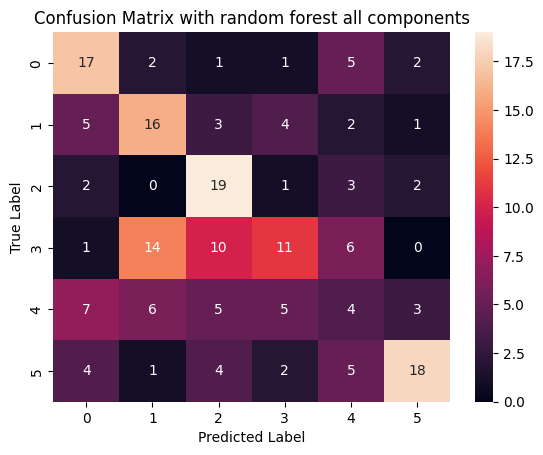

In [105]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_data_features, y_train)
y_pred = rf_classifier.predict(test_data_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with random forest all components: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred)
print("Classification Report with random forest all components:\n", report)

y_probs = rf_classifier.predict_proba(test_data_features)
logloss = log_loss(y_test, y_probs)
print(f"\nLog Loss with random forest all components: {logloss}\n")

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix with random forest all components")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### crushing model

In [106]:
# xgb_classifier_pca = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# xgb_classifier_pca.fit(train_data_features, y_train)

# y_pred = xgb_classifier_pca.predict(test_data_features)

# accuracy_pca = accuracy_score(y_test, y_pred)
# print(f"Accuracy with XGBoost  all components: {accuracy_pca * 100:.2f}%")

# report_pca = classification_report(y_test, y_pred)
# print("Classification Report with XGBoost  all components:\n", report_pca)

# y_probs = xgb_classifier_pca.predict_proba(test_data_features)

# logloss = log_loss(y_test, y_probs)
# print(f"Log Loss with XGBoost  all components: {logloss}")

# conf_matrix = confusion_matrix(y_test, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt="d")
# plt.title("Confusion Matrix with XGBoost  all components")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

### pca

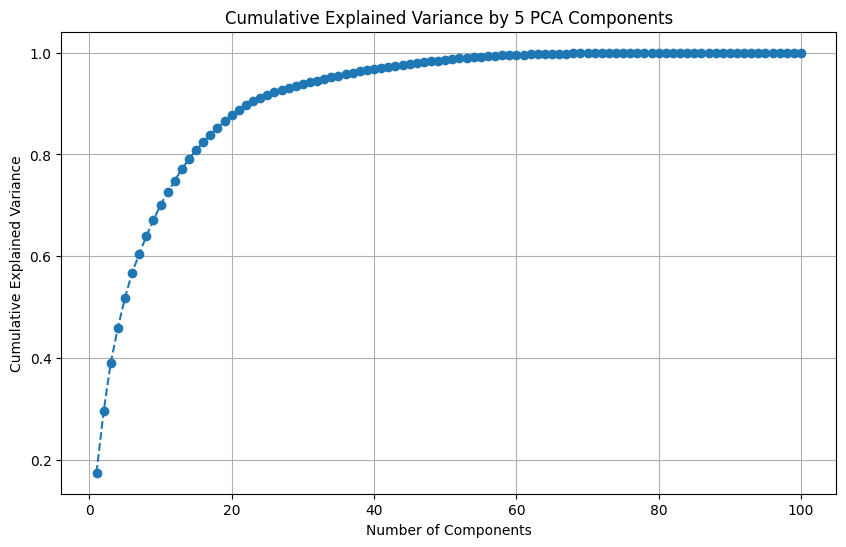

Explained variance ratio per component:
Component 1: 17.4062%
Component 2: 12.0584%
Component 3: 9.5501%
Component 4: 6.8555%
Component 5: 5.9476%
Component 6: 4.8862%
Component 7: 3.7294%
Component 8: 3.4779%
Component 9: 3.1499%
Component 10: 3.0037%
Component 11: 2.4508%
Component 12: 2.3299%
Component 13: 2.3076%
Component 14: 1.9247%
Component 15: 1.7948%
Component 16: 1.5008%
Component 17: 1.4576%
Component 18: 1.3898%
Component 19: 1.2846%
Component 20: 1.1571%
Component 21: 1.1484%
Component 22: 0.8332%
Component 23: 0.8028%
Component 24: 0.6255%
Component 25: 0.5887%
Component 26: 0.5209%
Component 27: 0.4622%
Component 28: 0.4542%
Component 29: 0.3745%
Component 30: 0.3713%
Component 31: 0.3514%
Component 32: 0.3320%
Component 33: 0.3277%
Component 34: 0.3252%
Component 35: 0.3239%
Component 36: 0.2905%
Component 37: 0.2814%
Component 38: 0.2674%
Component 39: 0.2555%
Component 40: 0.2221%
Component 41: 0.2090%
Component 42: 0.2063%
Component 43: 0.1955%
Component 44: 0.1851%

In [107]:
# visualise only 100  copmponents

from sklearn.decomposition import PCA
n_components = 100

pca = PCA(n_components=n_components)
pca.fit(train_data_features)
pca_components = pca.transform(train_data_features)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by 100 PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print("Explained variance ratio per component:")
for i, variance in enumerate(explained_variance_ratio, start=1):
    variance_in_percentage = variance * 100
    print(f"Component {i}: {variance_in_percentage:.4f}%")
cumulative_explained_variance *= 100
print(f"\nCumulative explained variance by {n_components} components: {cumulative_explained_variance[-1]:.2f}%")

In [108]:
top_components = 35
print(f"Cumulative explained variance of top {top_components} components: {cumulative_explained_variance[top_components - 1]:.2f}%")

Cumulative explained variance of top 35 components: 95.50%


In [109]:
pca_train_components = pca.transform(train_data_features)[:, :top_components]
pca_test_components = pca.transform(test_data_features)[:, :top_components]
X_train_selected_pca = pca_train_components
X_test_selected_pca = pca_test_components

In [110]:
test_data_features.shape

(192, 120000)

In [111]:
X_train_selected_pca.shape,X_test_selected_pca.shape

((768, 35), (192, 35))

Accuracy with PCA RandomForest components: 39.06%
Classification Report with PCA RandomForest components:
               precision    recall  f1-score   support

           0       0.48      0.57      0.52        28
           1       0.38      0.48      0.43        31
           2       0.35      0.41      0.38        27
           3       0.65      0.31      0.42        42
           4       0.21      0.23      0.22        30
           5       0.37      0.38      0.38        34

    accuracy                           0.39       192
   macro avg       0.41      0.40      0.39       192
weighted avg       0.42      0.39      0.39       192

Log Loss with randomforest PCA  components: 1.523083710602674


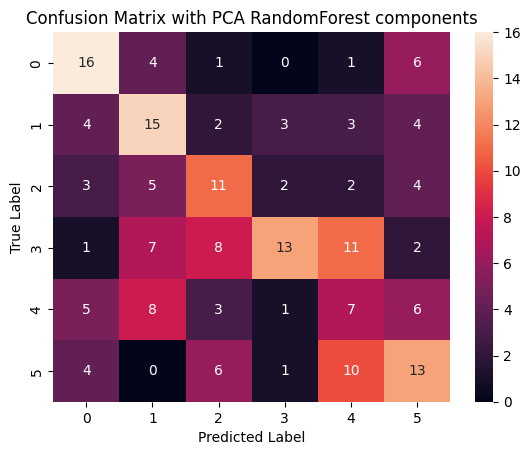

In [112]:
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca.fit(X_train_selected_pca, y_train)
y_pred_pca = rf_classifier_pca.predict(X_test_selected_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA RandomForest components: {accuracy_pca * 100:.2f}%")

report_pca = classification_report(y_test, y_pred_pca)
print("Classification Report with PCA RandomForest components:\n", report_pca)

y_probs_pca = rf_classifier_pca.predict_proba(X_test_selected_pca)

logloss_pca = log_loss(y_test, y_probs_pca)
print(f"Log Loss with randomforest PCA  components: {logloss_pca}")

conf_matrix = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix with PCA RandomForest components")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Accuracy with PCA XGBoost components: 38.54%
Classification Report with PCA XGBoost components:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57        28
           1       0.35      0.42      0.38        31
           2       0.42      0.48      0.45        27
           3       0.43      0.21      0.29        42
           4       0.21      0.30      0.25        30
           5       0.45      0.38      0.41        34

    accuracy                           0.39       192
   macro avg       0.40      0.40      0.39       192
weighted avg       0.40      0.39      0.38       192

Log Loss with XGBoost  PCA components: 1.9562272603380872


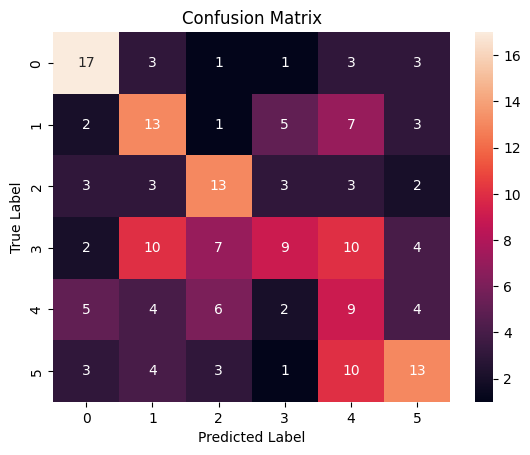

In [113]:
xgb_classifier_pca = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_classifier_pca.fit(X_train_selected_pca, y_train)

y_pred_pca = xgb_classifier_pca.predict(X_test_selected_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA XGBoost components: {accuracy_pca * 100:.2f}%")

report_pca = classification_report(y_test, y_pred_pca)
print("Classification Report with PCA XGBoost components:\n", report_pca)

y_probs_pca = xgb_classifier_pca.predict_proba(X_test_selected_pca)

logloss_pca = log_loss(y_test, y_probs_pca)
print(f"Log Loss with XGBoost  PCA components: {logloss_pca}")

conf_matrix = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### current problems:
 - too many smaples crush the program.
 - XGBoost without PCA crush the program.
 - doing sample which are not sub_spectogram_id == 0 were tried here and didn't changed anytihng. 
 - the entire dataset is 106800 (different spectpgrams) X 300 (rows) X 400(cols)...other processing solution is required
 - furthermore, an attempt to use the original baseline model flawed logic was done here (baseline model flatten with random forest) which show worest result than before, which raise the suspicion that the data was polluted while processed there..